In [1]:
import torch
import wandb
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
from tinyai.imports import *
from torcheval.metrics import *
import timm

torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 100

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=10

# Load the FashionMNIST dataset from Hugging Face
dataset = load_dataset('fashion_mnist')

bs= 512
epochs = 25
lr = 1e-2

xmean,xstd = 0.28, 0.35
@inplace
def transformi(b): b['image'] = [(((F.pad(TF.to_tensor(o), (2,2,2,2))) -xmean)/xstd) for o in b['image']]


tds = dataset.with_transform(transformi)
dls = DataLoaders.from_dd(tds,batch_size=bs,test=True ,split = 0.1, num_workers=10, pin_memory=True)
xb,yb = next(iter(dls.train))
xb.mean(), xb.std()

def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]).to('cuda'),tfm_y(b[1].to('cuda'))
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

/home/billy/base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/billy/base/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def test_model_accuracy(model, dataloader, metrics):
    model.eval()
    accuracy_metric = metrics['accuracy']
    precision_metric = metrics['precision']
    recall_metric = metrics['recall']

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(def_device))
            _, predicted = torch.max(outputs.data, 1)
            accuracy_metric.update(predicted.to('cpu'), labels)
            precision_metric.update(predicted.to('cpu'), labels)
            recall_metric.update(predicted.to('cpu'), labels)

    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()

    model.train()
    return accuracy, precision, recall

In [3]:
import wandb
class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project='diploma', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)

    def before_fit(self, learn): wandb.init(project=self.project, config=self.config, name=self.config['name'])
    def after_fit(self, learn):
        #wandb.log({'color_dim': wandb.Image(astats.color_dim())})
        #wandb.log({'dead_chart': wandb.Image(astats.dead_chart())})
        #wandb.log({'plot_stats':wandb.Image(astats.plot_stats())})


        metrics = {
            'accuracy': MulticlassAccuracy(num_classes=10),
            'precision': MulticlassPrecision(num_classes=10, average='macro'),
            'recall': MulticlassRecall(num_classes=10, average='macro')
        }
        accuracy, precision, recall = test_model_accuracy(learn.model, dls.test, metrics)
        wandb.log({'test_accuracy': accuracy, 'test_precision': precision, 'test_recall': recall})
        wandb.finish()

    def after_epoch(self, learn):
        super().after_epoch(learn)
        wandb.log({'lr':learn.opt.param_groups[-1]['lr']})
        
        # Save the model on the 5th, 10th, and 20th epochs
        if learn.epoch == 4 or learn.epoch == 9 or learn.epoch == 19 or learn.epoch == 24:
            metrics = {
                'accuracy': MulticlassAccuracy(num_classes=10),
                'precision': MulticlassPrecision(num_classes=10, average='macro'),
                'recall': MulticlassRecall(num_classes=10, average='macro')
            }

            accuracy, precision, recall = test_model_accuracy(learn.model, dls.test, metrics)
            wandb.log({'test_accuracy': accuracy, 'test_precision': precision, 'test_recall': recall})

            model_filename = f"{self.config['name']}_{learn.epoch + 1}.pth"
            torch.save(learn.model.state_dict(), f'models/{model_filename}')
            wandb.save(model_filename)

    def _log(self, d):
        if d.get('train') == 'train':
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
        print(d)


    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({'loss':learn.loss})
        wandb.log({'accuracy': learn.metrics.metrics['accuracy'].compute()})
        wandb.log({'precision': learn.metrics.metrics['precision'].compute()})
        wandb.log({'recall': learn.metrics.metrics['recall'].compute()})


In [4]:
resnet10t = timm.create_model('resnet10t', pretrained=False, num_classes=10, in_chans=1)
resnet18 = timm.create_model('resnet18d', pretrained=False, num_classes=10, in_chans=1)
resnet50 = timm.create_model('resnet50', pretrained=False, num_classes=10, in_chans=1)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: afterhoursbilly. Use `wandb login --relogin` to force relogin


accuracy,precision,recall,loss,epoch,train
0.643,0.638,0.643,1.030,0,train
0.659,0.725,0.656,0.990,0,eval
0.790,0.785,0.790,0.557,1,train
0.760,0.794,0.760,0.622,1,eval
0.816,0.813,0.816,0.489,2,train
0.690,0.772,0.685,0.901,2,eval
0.831,0.830,0.831,0.446,3,train
0.762,0.793,0.762,0.705,3,eval
0.848,0.847,0.848,0.407,4,train
0.755,0.813,0.756,0.668,4,eval


{'loss': '1.030', 'epoch': 0, 'train': 'train'}


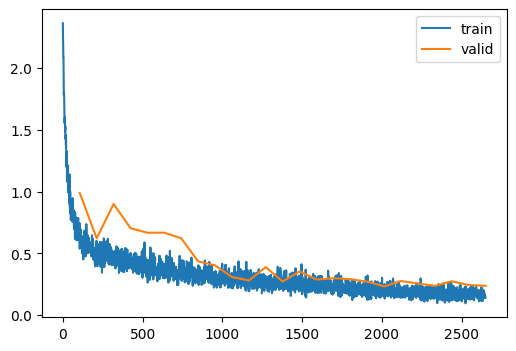

{'loss': '0.990', 'epoch': 0, 'train': 'eval'}
{'loss': '0.557', 'epoch': 1, 'train': 'train'}
{'loss': '0.622', 'epoch': 1, 'train': 'eval'}
{'loss': '0.489', 'epoch': 2, 'train': 'train'}
{'loss': '0.901', 'epoch': 2, 'train': 'eval'}
{'loss': '0.446', 'epoch': 3, 'train': 'train'}
{'loss': '0.705', 'epoch': 3, 'train': 'eval'}
{'loss': '0.407', 'epoch': 4, 'train': 'train'}
{'loss': '0.668', 'epoch': 4, 'train': 'eval'}
{'loss': '0.373', 'epoch': 5, 'train': 'train'}
{'loss': '0.669', 'epoch': 5, 'train': 'eval'}
{'loss': '0.361', 'epoch': 6, 'train': 'train'}
{'loss': '0.623', 'epoch': 6, 'train': 'eval'}
{'loss': '0.334', 'epoch': 7, 'train': 'train'}
{'loss': '0.436', 'epoch': 7, 'train': 'eval'}
{'loss': '0.327', 'epoch': 8, 'train': 'train'}
{'loss': '0.404', 'epoch': 8, 'train': 'eval'}
{'loss': '0.294', 'epoch': 9, 'train': 'train'}
{'loss': '0.310', 'epoch': 9, 'train': 'eval'}
{'loss': '0.288', 'epoch': 10, 'train': 'train'}
{'loss': '0.281', 'epoch': 10, 'train': 'eval'}
{

accuracy,▁▃▆▅▆▆▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
loss,█▅▄▅▃▃▅▃▂▃▂▂▃▃▂▂▂▂▂▃▂▂▃▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▂▁
lr,▂▂▂▂▄▅▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
precision,▁▃▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
recall,▁▃▆▅▆▆▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
test_accuracy,▁▁▇▇█████
test_precision,▁▁▆▆▇▇███
test_recall,▁▁▇▇█████
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▇▅▅▅▅▃▃▂▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.91183


In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=10),
                    precision=MulticlassPrecision(num_classes=10, average='macro'),
                    recall=MulticlassRecall(num_classes=10, average='macro'))


tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)


wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':f'resnet10t'}, project='diploma')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), augcb, wandbcb]
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(resnet10t, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: afterhoursbilly. Use `wandb login --relogin` to force relogin


accuracy,precision,recall,loss,epoch,train
0.659,0.659,0.659,0.973,0,train
0.634,0.736,0.630,1.107,0,eval
0.791,0.785,0.791,0.552,1,train
0.754,0.803,0.753,0.624,1,eval
0.815,0.813,0.815,0.491,2,train
0.788,0.834,0.788,0.519,2,eval
0.832,0.830,0.832,0.445,3,train
0.800,0.814,0.799,0.544,3,eval
0.845,0.844,0.845,0.410,4,train
0.769,0.825,0.768,0.608,4,eval


{'loss': '0.973', 'epoch': 0, 'train': 'train'}


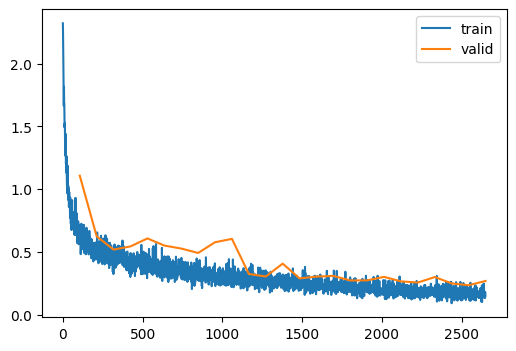

{'loss': '1.107', 'epoch': 0, 'train': 'eval'}
{'loss': '0.552', 'epoch': 1, 'train': 'train'}
{'loss': '0.624', 'epoch': 1, 'train': 'eval'}
{'loss': '0.491', 'epoch': 2, 'train': 'train'}
{'loss': '0.519', 'epoch': 2, 'train': 'eval'}
{'loss': '0.445', 'epoch': 3, 'train': 'train'}
{'loss': '0.544', 'epoch': 3, 'train': 'eval'}
{'loss': '0.410', 'epoch': 4, 'train': 'train'}
{'loss': '0.608', 'epoch': 4, 'train': 'eval'}
{'loss': '0.383', 'epoch': 5, 'train': 'train'}
{'loss': '0.551', 'epoch': 5, 'train': 'eval'}
{'loss': '0.360', 'epoch': 6, 'train': 'train'}
{'loss': '0.527', 'epoch': 6, 'train': 'eval'}
{'loss': '0.339', 'epoch': 7, 'train': 'train'}
{'loss': '0.492', 'epoch': 7, 'train': 'eval'}
{'loss': '0.317', 'epoch': 8, 'train': 'train'}
{'loss': '0.577', 'epoch': 8, 'train': 'eval'}
{'loss': '0.294', 'epoch': 9, 'train': 'train'}
{'loss': '0.604', 'epoch': 9, 'train': 'eval'}
{'loss': '0.284', 'epoch': 10, 'train': 'train'}
{'loss': '0.325', 'epoch': 10, 'train': 'eval'}
{

accuracy,▁▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
loss,█▅▄▅▄▄▄▄▃▃▂▃▂▂▂▃▂▂▂▃▂▂▂▂▂▃▂▂▂▂▁▂▁▁▂▂▁▁▂▁
lr,▂▂▂▂▄▅▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
precision,▁▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
recall,▁▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
test_accuracy,▁▁▁▁█████
test_precision,▁▁▂▂█████
test_recall,▁▁▁▁█████
train_loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▄▄▃▃▄▄▂▂▂▁▂▂▁▁▂▁▁▂▁▁▁
accuracy,0.90383


accuracy,precision,recall,loss,epoch,train
0.510,0.503,0.510,1.371,0,train
0.437,0.410,0.432,2.186,0,eval
0.710,0.703,0.710,0.779,1,train
0.410,0.501,0.406,4.418,1,eval
0.753,0.748,0.753,0.679,2,train
0.601,0.665,0.597,1.312,2,eval
0.779,0.777,0.779,0.602,3,train
0.718,0.758,0.716,0.898,3,eval
0.805,0.802,0.805,0.524,4,train
0.680,0.701,0.677,0.877,4,eval


{'loss': '1.371', 'epoch': 0, 'train': 'train'}


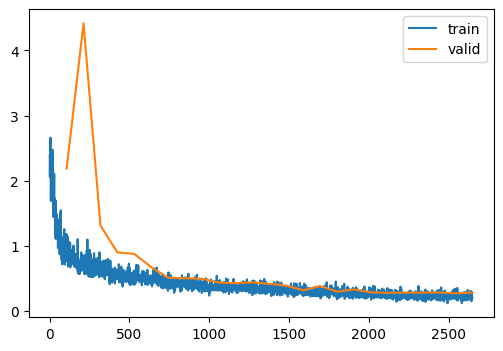

{'loss': '2.186', 'epoch': 0, 'train': 'eval'}
{'loss': '0.779', 'epoch': 1, 'train': 'train'}
{'loss': '4.418', 'epoch': 1, 'train': 'eval'}
{'loss': '0.679', 'epoch': 2, 'train': 'train'}
{'loss': '1.312', 'epoch': 2, 'train': 'eval'}
{'loss': '0.602', 'epoch': 3, 'train': 'train'}
{'loss': '0.898', 'epoch': 3, 'train': 'eval'}
{'loss': '0.524', 'epoch': 4, 'train': 'train'}
{'loss': '0.877', 'epoch': 4, 'train': 'eval'}
{'loss': '0.506', 'epoch': 5, 'train': 'train'}
{'loss': '0.674', 'epoch': 5, 'train': 'eval'}
{'loss': '0.473', 'epoch': 6, 'train': 'train'}
{'loss': '0.511', 'epoch': 6, 'train': 'eval'}
{'loss': '0.421', 'epoch': 7, 'train': 'train'}
{'loss': '0.502', 'epoch': 7, 'train': 'eval'}
{'loss': '0.408', 'epoch': 8, 'train': 'train'}
{'loss': '0.496', 'epoch': 8, 'train': 'eval'}
{'loss': '0.378', 'epoch': 9, 'train': 'train'}
{'loss': '0.436', 'epoch': 9, 'train': 'eval'}
{'loss': '0.362', 'epoch': 10, 'train': 'train'}
{'loss': '0.428', 'epoch': 10, 'train': 'eval'}
{

accuracy,▁▃▅▂▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇██████████████
loss,▄▂▂█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▂▂▂▂▄▅▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
precision,▁▃▅▃▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇██████████████
recall,▁▃▅▂▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇██████████████
test_accuracy,▁▁▆▆█████
test_precision,▁▁▆▆█████
test_recall,▁▁▆▆█████
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.89067


In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=10),
                    precision=MulticlassPrecision(num_classes=10, average='macro'),
                    recall=MulticlassRecall(num_classes=10, average='macro'))

for model,ver in [(resnet18,18), (resnet50,50)]:
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)


    wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':f'{resnet18._get_name()}{ver}'}, project='diploma')
    cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), augcb, wandbcb]
    xtra = [BatchSchedCB(sched)]
    learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
    learn.fit(epochs)

accuracy,precision,recall,loss,epoch,train
0.456,0.449,0.456,1.521,0,train
0.493,0.651,0.494,1.263,0,eval
0.701,0.693,0.702,0.804,1,train
0.648,0.688,0.649,0.971,1,eval
0.752,0.747,0.752,0.658,2,train
0.731,0.754,0.729,0.725,2,eval
0.776,0.772,0.776,0.600,3,train
0.750,0.788,0.749,0.781,3,eval
0.802,0.800,0.802,0.528,4,train
0.707,0.694,0.703,0.706,4,eval


{'loss': '1.521', 'epoch': 0, 'train': 'train'}


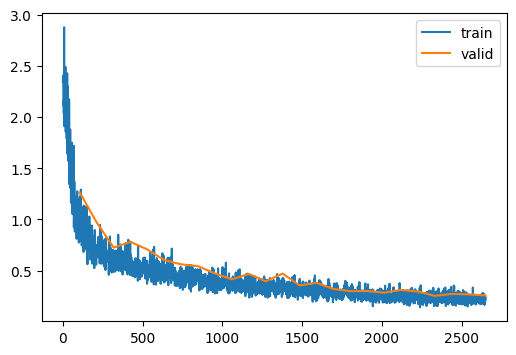

{'loss': '1.263', 'epoch': 0, 'train': 'eval'}
{'loss': '0.804', 'epoch': 1, 'train': 'train'}
{'loss': '0.971', 'epoch': 1, 'train': 'eval'}
{'loss': '0.658', 'epoch': 2, 'train': 'train'}
{'loss': '0.725', 'epoch': 2, 'train': 'eval'}
{'loss': '0.600', 'epoch': 3, 'train': 'train'}
{'loss': '0.781', 'epoch': 3, 'train': 'eval'}
{'loss': '0.528', 'epoch': 4, 'train': 'train'}
{'loss': '0.706', 'epoch': 4, 'train': 'eval'}
{'loss': '0.506', 'epoch': 5, 'train': 'train'}
{'loss': '0.603', 'epoch': 5, 'train': 'eval'}
{'loss': '0.466', 'epoch': 6, 'train': 'train'}
{'loss': '0.561', 'epoch': 6, 'train': 'eval'}
{'loss': '0.434', 'epoch': 7, 'train': 'train'}
{'loss': '0.543', 'epoch': 7, 'train': 'eval'}
{'loss': '0.396', 'epoch': 8, 'train': 'train'}
{'loss': '0.472', 'epoch': 8, 'train': 'eval'}
{'loss': '0.384', 'epoch': 9, 'train': 'train'}
{'loss': '0.415', 'epoch': 9, 'train': 'eval'}
{'loss': '0.363', 'epoch': 10, 'train': 'train'}
{'loss': '0.468', 'epoch': 10, 'train': 'eval'}
{

accuracy,▁▃▅▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇████████████████████
loss,█▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,▂▂▂▂▄▅▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁
precision,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
recall,▁▃▅▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇████████████████████
test_accuracy,▁▁▆▆▇▇███
test_precision,▁▁▆▆▇▇███
test_recall,▁▁▆▆▇▇███
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▅▄▃▃▃▃▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.90017


In [13]:
lr = lr/2
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=10),
                    precision=MulticlassPrecision(num_classes=10, average='macro'),
                    recall=MulticlassRecall(num_classes=10, average='macro'))


tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)


wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'bs':bs, 'name':f'resnet50_v'}, project='diploma')
cbs = [DeviceCB('cuda'), metrics, ProgressCB(plot=True), augcb, wandbcb]
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(resnet50, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [10]:
!sudo shutdown

Shutdown scheduled for Wed 2024-05-08 03:58:59 CEST, use 'shutdown -c' to cancel.
